In [1]:
import argparse
import os
path = os.getcwd()
path=path[:path.find('estimate-innovation')+20]
# No = (os.path.basename(__file__))[-4]
No = "0" # notebook用
# print('実験No.'+No)
import warnings
warnings.simplefilter('ignore')# 警告を非表示
import numpy as np
np.set_printoptions(precision=4, floatmode='fixed', suppress=True)
import matplotlib.pyplot as plt
from scipy import stats
import math
import sys
sys.path.append(path)
import random
import time
import statsmodels.api as sm
from scipy.stats import norm
import japanize_matplotlib
from scipy.stats import gaussian_kde

import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
# 人工データを生成してくれる機械が置いてあるところ
import tsModel
# 学習用のニューラルネットが置いてあるところ
import models
# p-Wasserstein距離の関数
import Wasserstein
path

'/home/lab/ryuichi/Documents/research/estimate-innovation/'

### GPUが使えるかどうかの確認

In [2]:
import checkGPU
cuda, device = checkGPU.checkGPU()

GPUが使えます。
GPUを使いますか？ （Yes：1, No：0）： 1
使用するGPUの番号を入れてください : 0


### 非線形ARモデルに従う時系列の作成

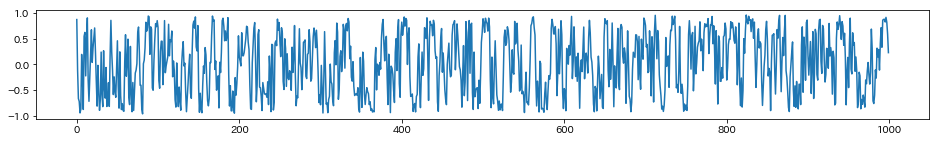

In [3]:
phi_a = [1.0, -0.5, 0.7, -0.4] ; phi_b = [0]
p = len(phi_a) ; q = len(phi_b)
dataSeed=5
N = 1000
data = tsModel.nonLinearARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='uniform', sigma=1/np.sqrt(3))
inno = tsModel.nonLinearARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='uniform', return_innovation=True, sigma=1/np.sqrt(3))
# 描画
plt.figure(figsize=(16,2)) ; plt.plot(data) ; plt.show()
# データをGPUかCPUに乗っける
data = torch.from_numpy(data).float().to(device)

### 推定に用いる$\hat p$の設定

In [4]:
hat_p = 4

### データの整形

In [5]:
# train と　validation　に分ける
trainData = data[:N//10*9]
valData = data[N//10*9:]

<img src="../images/batchの作り方.png" width="500">

In [6]:
def makeMatrix(data, hat_p):
    data = data.view(1,-1)
    return torch.cat([data[:,i:i+hat_p+1] for i in range(data.shape[1]-hat_p)],dim=0)
trainMatrix = makeMatrix(trainData, hat_p=hat_p)
valMatrix = makeMatrix(valData, hat_p=hat_p)

In [7]:
def makebatchMatrix(trainMatrix, b1=6, b2=64, min_margin=10, seed=None):
    """
    b1：いくつ連続した（X[t-p:t], X[t]）を一組みとするか
    b2：連続の（X[t-p:t], X[t]）の組みをいくつ作るか
    min_margin：必ずこの長さ分は間を空けてサンプルする。
    """
    N = trainMatrix.shape[0]+trainMatrix.shape[1]-1# 系列の長さ
    freedom_space = N - (trainMatrix.shape[1]+b1-1 + (b2-1)*min_margin)
    if freedom_space<=0:
        print("データ数がたりない")
        return None

    np.random.seed(seed=seed)
    # 残った自由なスペースをランダムにb2+1個に振り分ける
    margin = np.random.multinomial(n=freedom_space, pvals=[1/(b2+1)]*(b2+1)) + min_margin
    margin[0]-=min_margin
    cumsum_margin = np.cumsum(margin)
    trainMatrix = trainMatrix.view(1, trainMatrix.shape[0], trainMatrix.shape[1])
    return torch.cat([trainMatrix[:,cumsum_margin[i]:cumsum_margin[i]+b1] for i in range(b2)])
    
aa=makebatchMatrix(trainMatrix,b1=4, b2=32, min_margin=14, seed=None)

In [8]:
aa.shape

torch.Size([32, 4, 5])

In [9]:
makebatchMatrix(valMatrix,b1=4, b2=1, min_margin=14, seed=None).shape

torch.Size([1, 4, 5])

### NNを学習する時のハイパラを決定する

In [10]:
# 学習する推定モデルの形状や学習方法なんかを決定します
# 学習時のハイパラの決定（入力を受け付ける）
parser = argparse.ArgumentParser()
parser.add_argument("--generator_seed", type=int, default=0, help="generatorのパラメータの初期値のシード")
parser.add_argument("--predictor_seed", type=int, default=0, help="predictorのパラメータの初期値のシード")
parser.add_argument("--batch_size", type=int, default=1, help="batchの大きさ")
# parser.add_argument("--training_seed", type=int, default=0, help="訓練データを学習させる順番を決めるシード")
parser.add_argument("--n_epochs", type=int, default=1000, help="学習させる回数")

opt = parser.parse_args(args=[]) # .ipynbの場合はこちらを使用

### NNモデルを作成($F$は学習済の$F$を読み込む)

In [11]:
predictor = models.semiLinearPredictNet(input_size=hat_p+1)
preF_paramPath = path+"kurtosis_loss/parameters/p{0}/pre_semiLinearPredictor.pth".format(hat_p)
predictor.load_state_dict(torch.load(preF_paramPath))
predictor = predictor.to(device)

torch.manual_seed(opt.generator_seed)
generator = models.FullConnectGenerator(input_size = hat_p+1, output_size=1)
generator = generator.to(device)

In [12]:
input_tensor = torch.rand([32, 5]).to(device)
print(predictor(input_tensor).shape)
input_tensor = torch.rand([32, 5]).to(device)
print(generator(input_tensor).shape)

torch.Size([32, 1])
torch.Size([32, 1])


### $\varepsilon$からの重さを1にする

In [13]:
predictor.fc1.weight.data[0][0] = 1

In [14]:
predictor.state_dict()

OrderedDict([('scale', tensor([1.2862], device='cuda:0')),
             ('fc1.weight',
              tensor([[ 1.0000, -0.2030,  0.3660, -0.2481,  0.6023]], device='cuda:0'))])

### 最適化手法の設定

In [15]:
optimizer_F = torch.optim.Adam(params=predictor.parameters(), lr=0.0001 )
optimizer_G = torch.optim.Adam(params=generator.parameters(), lr=0.0001 )
# optimizer_F = torch.optim.SGD(params=predictor.parameters(), lr = 0.00005)

### Lossの設計

In [16]:
batchMatrix = generator(aa)
batchMatrix.shape

torch.Size([32, 4, 1])

In [17]:
mseLoss = nn.MSELoss()
mseLoss = mseLoss.to(device)
def Mutual_Information(batchMatrix):
    return - (1/12*(batchMatrix**3).mean(axis=0) + 1/48*((batchMatrix**4).mean(axis=0) - 3*((batchMatrix**2).mean(axis=0))**2)**2).sum()
# Variable(Wasserstein.pWasserstein(hat_normeps_t.view(opt.batch_size), p=1), requires_grad=True).to(device)

### 学習に必要なリスト

In [18]:
train_lossList_mse = []
val_lossList_mse = []
train_lossList_Wasser = []
val_lossList_Wasser = []

In [19]:
minLoss = np.inf
paramPath_F = path+"kurtosis_loss/parameters/p{0}/semiLinearPredictor.pth".format(hat_p)
paramPath_G = path+"kurtosis_loss/parameters/p{0}/FullConnectGenerator.pth".format(hat_p)

start = time.time()

for param in generator.parameters(): # generatorの勾配の更新をONにする
    param.requires_grad = True 
for param in predictor.parameters(): # predictorの勾配の更新をOFFにする
    param.requires_grad = False
PredictorTrainFlag = False

    
for epoch in range( opt.n_epochs):# epochごとの処理
    
    # たまにPredictorも学習する（勾配の更新を許可する）
    if epoch%10==100-1:
        PredictorTrainFlag = True
        for param in predictor.parameters():
            param.requires_grad = True
    
    train_epoch_loss_mse = 0 # itelationごとに出力されるLossのbatch平均を足しこむ変数（あとでitelationの回数で割ってlossListにappendする）
    for idx, sample in enumerate(trainMatrix[torch.randperm(n=trainMatrix.shape[0])]):# サンプルをランダムに出力しながらiterationする
        X = sample[:hat_p].view(1,-1)
        Y = sample[-1:].view(1,-1)
        """
        Generatorの学習
        """
        train_input_tensor_G = sample.view(1,-1)
        train_output_tensor_G = generator(train_input_tensor_G)
        train_input_tensor_F = torch.cat([train_output_tensor_G, X], axis=1)# ランダムな次元を追加
        train_output_tensor_F = predictor(train_input_tensor_F)
        
        mse_loss = mseLoss(train_output_tensor_F, Y)
        mse_loss.backward()# 勾配をとる
        optimizer_G.step()# 勾配情報と最適化手法を元にparameterを更新
        optimizer_G.zero_grad()
        
        # もしPredictorも学習するならしないとね
        if PredictorTrainFlag:
            optimizer_F.step()
            optimizer_F.zero_grad()

        train_epoch_loss_mse += mse_loss.item()
    train_lossList_mse.append(train_epoch_loss_mse/(idx+1))
    
    # そして再び不許可に。
    if PredictorTrainFlag:
        for param in predictor.parameters():
            param.requires_grad = False
        PredictorTrainFlag=False

    val_epoch_loss_mse = 0 # itelationごとに出力されるLossのbatch平均を足しこむ変数（あとでitelationの回数で割ってlossListにappendする）
    for idx, sample in enumerate(valMatrix[torch.randperm(n=valMatrix.shape[0])]):# サンプルをランダムに出力しながらiterationする
        X = sample[:hat_p].view(1,-1)
        Y = sample[-1:].view(1,-1)
        """
        Generatorの学習のvalidationの推移
        """
        val_input_tensor_G = sample.view(1,-1)
        val_output_tensor_G = generator(val_input_tensor_G)
        val_input_tensor_F = torch.cat([val_output_tensor_G, X], axis=1)
        val_output_tensor_F = predictor(val_input_tensor_F)
        
        mse_loss = mseLoss(val_output_tensor_F, Y)
        
        val_epoch_loss_mse += mse_loss.item()
    val_lossList_mse.append(val_epoch_loss_mse/(idx+1))
    
    if minLoss>val_lossList_mse[-1]:#+ val_lossList_Wasser[-1]:
        minLoss = val_lossList_mse[-1]#+ val_lossList_Wasser[-1]
        torch.save(generator.state_dict(), paramPath_G)
        torch.save(predictor.state_dict(), paramPath_F)    

    if epoch%100==100-1:
        print("epoch：{0}/{1}   val_loss_mse：{2: .4g}  val_loss_Wasser:{3: .4g}   経過時間：{4: .1f}秒".format(epoch+1, opt.n_epochs, val_lossList_mse[-1], 0, time.time()-start))

#     makebatchMatrix(trainMatrix,b1=4, b2=32, min_margin=14, seed=None)
#     break

epoch：100/1000   val_loss_mse： 0.0001046  val_loss_Wasser: 0   経過時間： 304.7秒
epoch：200/1000   val_loss_mse： 5.48e-05  val_loss_Wasser: 0   経過時間： 599.9秒
epoch：300/1000   val_loss_mse： 4.322e-05  val_loss_Wasser: 0   経過時間： 902.4秒
epoch：400/1000   val_loss_mse： 2.578e-05  val_loss_Wasser: 0   経過時間： 1210.7秒
epoch：500/1000   val_loss_mse： 3.236e-05  val_loss_Wasser: 0   経過時間： 1501.1秒
epoch：600/1000   val_loss_mse： 2.07e-05  val_loss_Wasser: 0   経過時間： 1809.5秒
epoch：700/1000   val_loss_mse： 2.63e-05  val_loss_Wasser: 0   経過時間： 2116.8秒
epoch：800/1000   val_loss_mse： 1.757e-05  val_loss_Wasser: 0   経過時間： 2422.4秒
epoch：900/1000   val_loss_mse： 1.928e-05  val_loss_Wasser: 0   経過時間： 2732.7秒
epoch：1000/1000   val_loss_mse： 3.102e-05  val_loss_Wasser: 0   経過時間： 3039.3秒


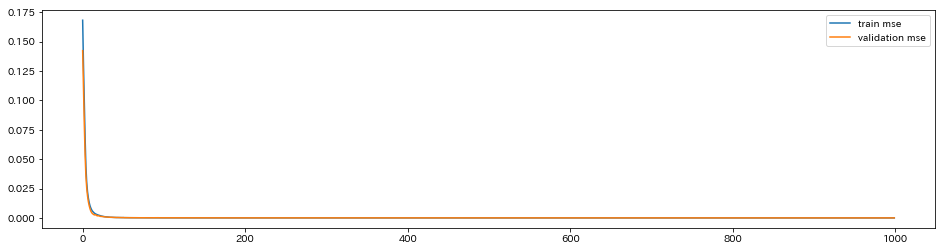

In [20]:
plt.figure(figsize=(16,4))
plt.plot(train_lossList_mse, label="train mse")
plt.plot(val_lossList_mse, label="validation mse")
# plt.plot(train_lossList_Wasser, label="train Wasserstein")
# plt.plot(val_lossList_Wasser, label="validation Wasserstein")
plt.legend()

In [21]:
predictor.state_dict()

OrderedDict([('scale', tensor([1.2862], device='cuda:0')),
             ('fc1.weight',
              tensor([[ 1.0000, -0.2030,  0.3660, -0.2481,  0.6023]], device='cuda:0'))])

In [22]:
generator.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.0068,  0.1286, -0.1485, -0.2164, -0.6055],
                      [ 0.0467, -0.0939,  0.1907,  0.0894, -0.3398],
                      [ 0.1049, -0.0920, -0.0785, -0.3921,  0.1851],
                      [-0.0335,  0.2821,  0.3067, -0.0628, -0.3117],
                      [-0.1199,  0.2994, -0.2618,  0.3827, -0.3775],
                      [-0.0799,  0.1762, -0.2619, -0.3229, -0.0898],
                      [-0.1901,  0.2154, -0.3384,  0.0078, -0.5017],
                      [-0.1132, -0.1815,  0.3996,  0.0891,  0.2506],
                      [ 0.0689, -0.1019,  0.1112, -0.1196, -0.6691],
                      [-0.2470,  0.2391,  0.2576, -0.1098,  0.0414],
                      [ 0.1949,  0.0202,  0.0756, -0.1015,  0.4590],
                      [-0.0634,  0.0030, -0.1182, -0.3725, -0.0026],
                      [ 0.0767, -0.0134, -0.1286, -0.2200,  0.5063],
                      [-0.0185, -0.1569,  0.2023, -0.0401,  0.5810],
      

### テスト

In [32]:
phi_a = [1.0, -0.5, 0.7, -0.4] ; phi_b = [0]
p = len(phi_a) ; q = len(phi_b)
dataSeed=2**32-1
N = 100
testData = tsModel.nonLinearARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='uniform', sigma=1/np.sqrt(3))
test_inno = tsModel.nonLinearARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='uniform', return_innovation=True, sigma=1/np.sqrt(3))
# 描画
# plt.figure(figsize=(16,2)) ; plt.plot(testData) ; plt.show()
# データをGPUかCPUに乗っける
testData = torch.from_numpy(testData).float().to(device)
testMatrix = makeMatrix(testData, hat_p=hat_p)

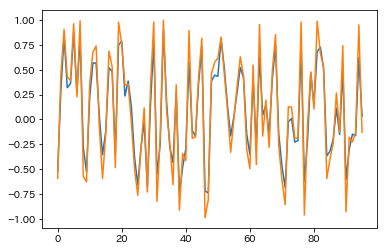

In [39]:
plt.plot(generator(testMatrix).detach().cpu().numpy())
plt.plot(test_inno[4:])